In [42]:
# magics: ensures that any changes to the modules loaded below will be re-loaded automatically
%load_ext autoreload
%autoreload 2

# load packages
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')


# load modules related to this exercise
import Exercise_4 as ex4

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Exercise 4: Introducing uncertainty

Consider the model with uncertainty:
$$\begin{aligned}
    V_{t}(W_{t}) & = \max_{c_{t}}\left\{ \sqrt{c_{t}} + \beta \sum_{i=1}^K V_{t+1}(W_t-c_t+\varepsilon_i)\pi_i  \right\} \\
 & \text{s.t.}\\
c_{t} & \leq  W_{t} , \,\forall t\\
c_{t} & \in  \mathbb{R}_+, \,\forall t \\
\varepsilon_i & \in \mathbb{N}  \text{ with probability } \pi_i\ge 0, i=1,\dots,K, \text{ and } \sum_{i=1}^K \pi_i=1
\end{aligned}$$
for $T=10$, $\beta=0.90$ and $W_{1}=10$. Further assume that $\epsilon_i$ follows a uniform distribution, $K=5$ and $\epsilon_{i} \in (0,1,2,3,4)$

### 1. Solve the model using *backward induction*, *grid search*, and *linear interpolation*.

In [23]:
# Setup specifications in class. 
class par: pass
par.beta = 0.90
par.W = 10
par.T = 10

par.K = 5

par.pi = np.ones(par.K)/par.K

par.eps = np.arange(par.K)

# Grid
par.num_W = 200
par.num_C = 200


# Solve the model
sol = ex4.solve_consumption_uncertainty(par)

### 2. Plot the value function and the consumption function for $t=1$. Make sure that both functions are increasing in $W$.

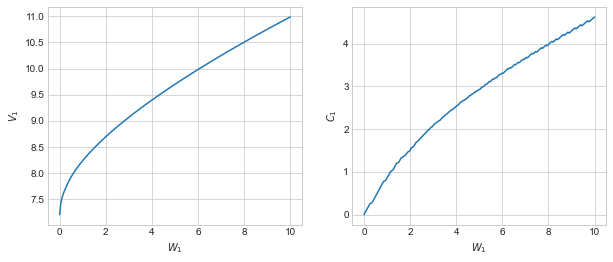

In [24]:
# Compare 
fig = plt.figure(figsize=(10,4)) # figsize is in inches...

ax = fig.add_subplot(1,2,1)
ax.plot(sol.grid_W[:,0],sol.V[:,0])
ax.set_xlabel("$W_1$")
ax.set_ylabel("$V_1$")
ax_right = fig.add_subplot(1,2,2)
ax_right.plot(sol.grid_W[:,0],sol.C[:,0])
ax_right.set_xlabel("$W_1$")
ax_right.set_ylabel("$C_1$")
plt.show()

### 3. Compare the value function and consumption function from ex. 1 with a determistic model, i.e. a model with no stochastic income growth.

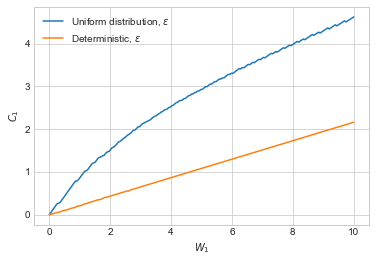

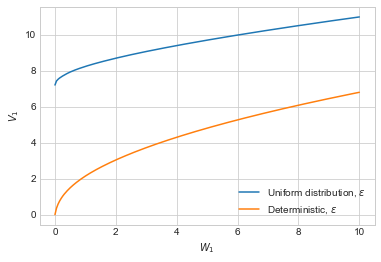

In [27]:
class par_fixed(par): pass  # Create a copy of the class
#par_fixed.pi = [1, 0, 0, 0, 0]
par_fixed.pi = [1]
par_fixed.eps = [0]
sol_fixed = ex4.solve_consumption_uncertainty(par_fixed)

# Compare 
plt.plot(sol.grid_W[:,0],sol.C[:,0], label='Uniform distribution, $\epsilon$',)
plt.plot(sol_fixed.grid_W[:,0],sol_fixed.C[:,0], label='Deterministic, $\epsilon$')
plt.ylabel('$C_1$')
plt.xlabel('$W_1$')
plt.legend();plt.show()
plt.plot(sol.grid_W[:,0],sol.V[:,0], label='Uniform distribution, $\epsilon$')
plt.plot(sol_fixed.grid_W[:,0],sol_fixed.V[:,0], label='Deterministic, $\epsilon$')
plt.ylabel('$V_1$')
plt.xlabel('$W_1$')
plt.legend();plt.show()

### 4. Reestimate the model assuming that $\pi = [0.05, 0.05, 0.8, 0.05, 0.05]$. How does the solution compare to the model with uniform uncertainty? 

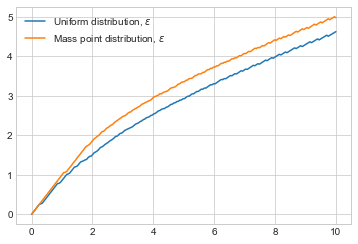

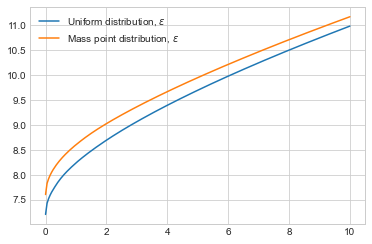

In [31]:
class par_mass(par): pass 
par_mass.pi = [0.05,0.05,0.8,0.05,0.05]
sol_mass = ex4.solve_consumption_uncertainty(par_mass)

# Compare 
plt.plot(sol.grid_W[:,0],sol.C[:,0], label='Uniform distribution, $\epsilon$')
plt.plot(sol_mass.grid_W[:,0],sol_mass.C[:,0], label='Mass point distribution, $\epsilon$')
plt.legend();plt.show()
plt.plot(sol.grid_W[:,0],sol.V[:,0], label='Uniform distribution, $\epsilon$')
plt.plot(sol_mass.grid_W[:,0],sol_mass.V[:,0], label='Mass point distribution, $\epsilon$')
plt.legend();plt.show()

### 5. Simulate a panel of *10,000* household for *10* periods and plot the mean of $C_t$. Everybody should be initialized with $W_1 = 10$. Simulate using the solution from ex.1 and the solution from ex. 4. What is the intuition of the graphs?

In [40]:
np.random.seed(10)

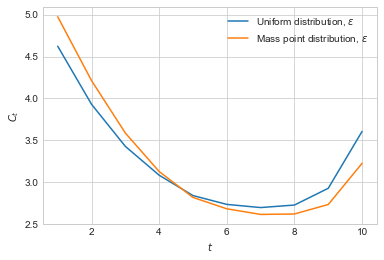

In [44]:
# Simulate 
np.random.seed(2022)  #Seed value, it ensures that the computer draw the same "random"-numbers each time

def simulate(sol, par, sim):
    
    # Allocate
    shape = (sim.simN, sim.T)
    simN = sim.simN
    W_ini = sim.W_ini
    W = sim.W_ini*np.ones(shape)
    C = np.nan +np.zeros(shape)
    mean = np.zeros(sim.T)
    np.random.seed(10)
    epsilon = np.random.randint(low=0, high=par.K+1, size=(sim.simN,sim.T))
    
    
    for t in range(par.T):
        interp = interpolate.interp1d(sol.grid_W[:,t],sol.C[:,t],bounds_error=False,fill_value='extrapolate')
        
        C[:,t] = interp(W[:,t])
        mean[t] = np.mean(C[:,t])
        
        if t<par.T-1:
            W[:,t+1] = W[:,t]-C[:,t] + epsilon[:,t]
        
          
        
    return mean

class sim: pass
sim.simN = 10000
sim.W_ini = 10
sim.T = 10
sim.T_grid = range(1,sim.T+1)

sim_uni = simulate(sol,par,sim)
sim_mass = simulate(sol_mass,par_mass,sim)

plt.plot(sim.T_grid,sim_uni, label='Uniform distribution, $\epsilon$')
plt.plot(sim.T_grid,sim_mass, label='Mass point distribution, $\epsilon$')
plt.ylabel('$C_t$')
plt.xlabel('$t$')
plt.legend();plt.show()